In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import os
import gc
import time
import importlib
import sklearn.preprocessing as pp
import sklearn.model_selection as ms
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from recommender import item_based, dummy as dummy_recommender, preprocessing as rpp, model_selection as rms,\
    tools as rtools, experiment_tools

import tag_genome_builder as tg_builder
from tag_genome_builder import model_selection as ms_tg_builder

from lib import tools
import config
import config_tag_recommender
def reload():
    importlib.reload(item_based)
    importlib.reload(dummy_recommender)
    importlib.reload(config)
    importlib.reload(tg_builder)
    importlib.reload(rpp)
    importlib.reload(rms)
    importlib.reload(tools)
    importlib.reload(config_tag_recommender)
    importlib.reload(ms_tg_builder)
    importlib.reload(rtools)
    importlib.reload(experiment_tools)
    
    

# input params

In [2]:
reload()
str_aggregated_path = config_tag_recommender.str_aggregated_path
str_movielens_movies_path = config_tag_recommender.str_movielense_movies_path

str_genome_scores = config_tag_recommender.str_genome_scores
str_tags = config_tag_recommender.str_tags
str_tag_ids = config_tag_recommender.str_tag_ids
str_rating_path = config_tag_recommender.str_rating_path
str_data_folder = config_tag_recommender.str_data_folder
minimum_no_of_frames = config_tag_recommender.minimum_no_of_frames
number_of_tag_per_movie = config_tag_recommender.number_of_tag_per_movie
n_jobs = 5

In [3]:
print('str_aggregated_path =', str_aggregated_path)
print('str_movielens_movies_path =', str_movielens_movies_path)
print('str_genome_scores =', str_genome_scores)
print('str_tags =', str_tags)
print('str_tag_ids =', str_tag_ids)
print('str_rating_path =', str_rating_path)
print('str_data_folder =', str_data_folder)
print('str_aggregated_path =', str_aggregated_path)
print('minimum_no_of_frames =', minimum_no_of_frames)
print('number_of_tag_per_movie =', number_of_tag_per_movie)

str_aggregated_path = ..\..\data\MA14KD_AGGREGATED.csv
str_movielens_movies_path = C:\Users\shossein\Documents\personal\research\data\ml-25m\movies.csv
str_genome_scores = ..\..\data\ml-25m\genome-scores.csv
str_tags = ..\..\data\ml-25m\tags.csv
str_tag_ids = ..\..\data\ml-25m\genome-tags.csv
str_rating_path = ..\..\data\ml-25m\ratings.csv
str_data_folder = ..\..\data
str_aggregated_path = ..\..\data\MA14KD_AGGREGATED.csv
minimum_no_of_frames = 10
number_of_tag_per_movie = 10


# Read inputs

In [4]:
df_tag_ids = pd.read_csv(str_tag_ids, index_col=config.tagId_col)

In [5]:
# df_tag_ids.head()

In [6]:
df_genome = pd.read_csv(str_genome_scores)

In [7]:
df_ratings = pd.read_csv(str_rating_path, nrows=None)

In [8]:
usecols = ['movieId', 'no_key_frames']
for i in range(1,11):
    usecols += [f'f{i}_median', f'f{i}_quartile1', f'f{i}_quartile3', f'f{i}_std'] 
print(len(usecols))
usecols = usecols


df_agg = pd.read_csv(str_aggregated_path, nrows=None, usecols=usecols, index_col=config.movieId_col).sort_index()
df_agg = df_agg[df_agg['no_key_frames'] >= minimum_no_of_frames]
df_agg.dropna(axis=1, thresh=len(df_agg) - 1000, inplace=True)

42


In [9]:
df_agg_not_in_genome = df_agg[~df_agg.index.isin(df_genome[config.movieId_col].unique())].copy()
df_agg_not_in_genome.shape

(7454, 39)

In [10]:
print('The size of datasets before filtering to the same:')
print('VF:', df_agg.shape,'Tag genome:', df_genome[config.movieId_col].nunique())
df_agg, df_genome = tg_builder.Base().filter_tag_and_vf_to_same(df_agg=df_agg, df_genome_scores=df_genome)
print('The size of datasets after filtering to the same:')
print('VF:', df_agg.shape,'Tag genome:', df_genome[config.movieId_col].nunique())

The size of datasets before filtering to the same:
VF: (13923, 39) Tag genome: 13816
The size of datasets after filtering to the same:
VF: (6469, 39) Tag genome: 6469


In [11]:
# vf_item_features =rpp.ItemFeature()
# vf_item_features.from_dataframe(df_agg)

## Genre

In [12]:
df_movie_lense = pd.read_csv(str_movielens_movies_path, usecols=[config.movieId_col, 'genres'], 
                             index_col=config.movieId_col
                            )

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
genres_vectorizer = CountVectorizer()
feature_matrix = genres_vectorizer.fit_transform(df_movie_lense['genres'])
item_ids = df_movie_lense.index
feature_names = genres_vectorizer.get_feature_names()
item_features_genre = item_based.ItemFeature(feature_matrix=feature_matrix,
                                            item_ids=item_ids,
                                            feature_names=feature_names)

# Compute tag genome based on visual features
## One movies exiting in both tag genome and VF dataset

In [14]:
normalizer = pp.QuantileTransformer(output_distribution='normal')
normalizer2 = pp.QuantileTransformer(output_distribution='normal')

# normalizer = pp.StandardScaler()


In [15]:
%%time
reload()
df_cv_tag_genome = ms_tg_builder.cross_val_predict(df_visual_features=df_agg,
                                                          df_genome_scores=df_genome,
                                                          normalizer_vf=normalizer,
                                                          n_splits=10, 
                                                          n_jobs=n_jobs)


Wall time: 19.4 s


## On movies with visual feature not in tag genome

In [16]:
from tag_genome_builder import TagGenomeBuilder
tag_genome_builder = TagGenomeBuilder(df_agg=df_agg,
                                      df_genome_scores=df_genome,
                                      normalizer_vf=normalizer2)
tag_genome_builder.fit(df_genome_score=df_genome, df_visual_feature=df_agg)

df_agg_not_in_genome_predicted = tag_genome_builder.predict(df_agg_not_in_genome, output_df=True)

df_predicted_tag_genome = pd.concat([df_cv_tag_genome, df_agg_not_in_genome_predicted], ignore_index=True)

In [17]:
item_features_vf_tg = rpp.get_item_feature_from_tag_genome(df_predicted_tag_genome, number_of_tag_per_movie)

# Filter rating to available movies and users with at least two ratings

In [18]:
df_ratings_filtered = df_ratings[df_ratings[config.movieId_col].isin(df_agg.index)]
user_activities = df_ratings_filtered[config.userId_col].value_counts()
df_ratings_filtered = df_ratings_filtered[df_ratings_filtered[config.userId_col].\
                                          isin(user_activities[user_activities > 1].index)]

# Train test split
## rating dataset and tag item features

In [19]:
reload()
df_rating_train, df_rating_test = \
    rms.train_test_split(df_ratings_filtered, item_features=None, strategy='sklearn', test_size=.25)

In [20]:
item_features_genre_train = item_features_genre.get_item_feature_by_list_of_items(
    df_rating_train[config.movieId_col].unique())
item_features_genre_test = item_features_genre.get_item_feature_by_list_of_items(
    df_rating_test[config.movieId_col].unique())

In [21]:
vf_normalizer = tg_builder.VisualFeatureNormalizer()
normalizer = pp.StandardScaler()
df_agg_train = df_agg.loc[df_rating_train[config.movieId_col].unique()]
df_agg_train_normalized = vf_normalizer.fit_transform(df_agg_train, normalizer)
df_agg_test = df_agg.loc[df_rating_test[config.movieId_col].unique()]
df_agg_test_normalized = vf_normalizer.transform(df_agg_test)

item_features_vf_train = rpp.ItemFeature()
item_features_vf_train.from_dataframe(df_agg_train_normalized)
item_features_vf_test = rpp.ItemFeature()
item_features_vf_test.from_dataframe(df_agg_test_normalized)



## tag genome computed using visual features

In [22]:
reload()
item_features_vf_tg_train, item_features_vf_tg_test = \
(item_features_vf_tg.get_item_feature_by_list_of_items(df_rating_train[config.movieId_col].unique()),
item_features_vf_tg.get_item_feature_by_list_of_items(df_rating_test[config.movieId_col].unique()))

# Train the content based recommender and predict on test on VF tag genome

In [23]:
reload()
df_rating_test = \
experiment_tools.get_predictions_for_different_number_of_tags(df_predicted_tag_genome,
                                                              np.arange(1,11),
                                                              df_rating_train,
                                                              df_rating_test,
                                                              n_jobs=n_jobs)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed: 176.0min
[Parallel(n_jobs=5)]: Done   2 out of  10 | elapsed: 176.2min remaining: 705.0min
[Parallel(n_jobs=5)]: Done   3 out of  10 | elapsed: 176.3min remaining: 411.5min
[Parallel(n_jobs=5)]: Done   4 out of  10 | elapsed: 176.4min remaining: 264.6min
[Parallel(n_jobs=5)]: Done   5 out of  10 | elapsed: 176.4min remaining: 176.4min
[Parallel(n_jobs=5)]: Done   6 out of  10 | elapsed: 357.1min remaining: 238.0min
[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed: 357.5min remaining: 153.2min
[Parallel(n_jobs=5)]: Done   8 out of  10 | elapsed: 358.7min remaining: 89.7min
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed: 360.6min remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed: 360.6min finished


# On visual features

In [58]:
# reload()
# recommend_vf = item_based.ItemBasedColabCos()
# recommend_vf.fit(df_rating_train, item_features_vf_train)
# test_users = df_rating_test[config.userId_col].unique()

In [ ]:
similarities_vf = metrics.pairwise.cosine_similarity(item_features_vf_test.feature_matrix, 
                                                     item_features_vf_train.feature_matrix)
similarities_vf.shape

1

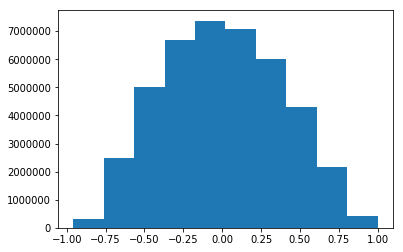

In [97]:
plt.hist(similarities_vf.ravel())
1

In [101]:
%%time
# threshold = 0
for threshold in [-.3, -.1, .1, .2]:
    reload()
    recommend_vf = item_based.ItemBasedColabCos()
    recommend_vf.fit(df_rating_train, item_features_vf_train)
    test_users = df_rating_test[config.userId_col].unique()
    recommendations_vf = recommend_vf.predict_on_list_of_users(test_users, 
                                                               df_rating_test, 
                                                               item_features_vf_test, 
                                                               n_jobs=n_jobs,
                                                               min_similarity=threshold)

    df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                       recommendations=recommendations_vf, 
                                                       prediction_column_suffix=f'vf_min_similarity_{threshold}')


ValueError: No objects to concatenate

# On genres

In [102]:
# reload()
# recommend_genres = item_based.ItemBasedColabCos()
# recommend_genres.fit(df_rating_train, item_features_genre_train)
# test_users = df_rating_test[config.userId_col].unique()

In [103]:
similarities_genre = metrics.pairwise.cosine_similarity(item_features_genre_test.feature_matrix, 
                                                        item_features_genre_train.feature_matrix)
similarities_genre.shape

(6469, 6469)

1

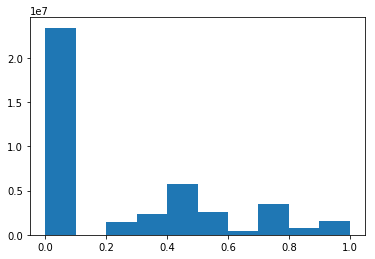

In [104]:
plt.hist(similarities_genre.ravel())
1

In [105]:
%%time
threshold = 0
# for threshold in [.1, .2, .3,]:
reload()
recommend_genres = item_based.ItemBasedColabCos()
recommend_genres.fit(df_rating_train, item_features_genre_train)
test_users = df_rating_test[config.userId_col].unique()
recommendations_genre = recommend_genres.predict_on_list_of_users(test_users, 
                                                           df_rating_test, 
                                                           item_features_genre_test, 
                                                           n_jobs=n_jobs,
                                                           min_similarity=threshold)

df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                   recommendations=recommendations_genre, 
                                                   prediction_column_suffix=f'genre')


Wall time: 30min 54s


# looking at the performance

1

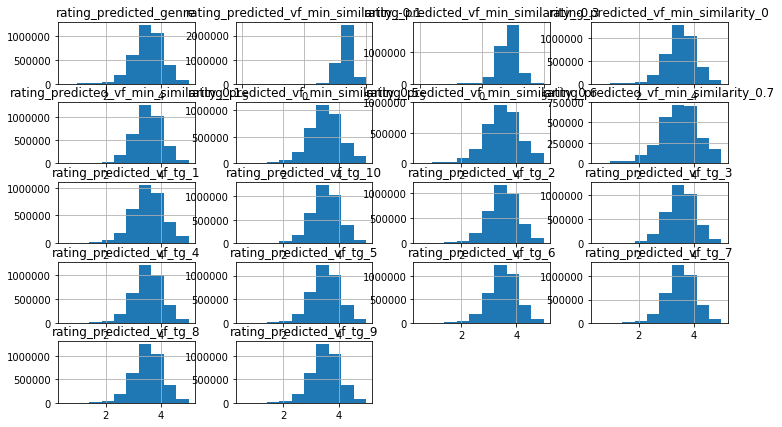

In [106]:
df_rating_test.filter(regex='rating_predicted').hist(figsize=(12, 7))
1

In [120]:
prediction_column_suffixes = []
for c in df_rating_test.filter(regex='rating_predicted').columns:
    c = c.replace('rating_predicted', '')
    c = c[1:] if len(c) > 0 else c
    prediction_column_suffixes.append(c)
prediction_column_suffixes

['vf_tg_1',
 'vf_tg_2',
 'vf_tg_3',
 'vf_tg_4',
 'vf_tg_5',
 'vf_tg_6',
 'vf_tg_7',
 'vf_tg_8',
 'vf_tg_9',
 'vf_tg_10',
 'vf_min_similarity_0.6',
 'vf_min_similarity_0.7',
 'vf_min_similarity_0.5',
 'vf_min_similarity_0',
 'vf_min_similarity_-0.3',
 'vf_min_similarity_-0.1',
 'vf_min_similarity_0.1',
 'genre']

In [121]:
reload()
df_performance_report = pd.concat([tools.performance_report(df_rating_test, 
                                                           prediction_column_suffix=alg) 
                                  for alg in prediction_column_suffixes]).sort_values('RMSE')
df_performance_report

,Average Score,MAE,RMSE,NRMSE,R2,Std of residuals,Avg of residuals,Coverage
genre,3.531761,0.723983,0.937480,0.265443,0.221010,0.937462,-0.005915,0.998100
vf_min_similarity_0,3.532149,0.746998,0.964662,0.273109,0.175324,0.964639,0.006664,0.999940
vf_min_similarity_0.1,3.532126,0.747739,0.965922,0.273468,0.173130,0.965897,0.006979,0.999749
vf_tg_10,3.531840,0.751398,0.971889,0.275179,0.162865,0.971880,0.004177,0.998467
vf_tg_9,3.531792,0.751427,0.972128,0.275251,0.162460,0.972123,0.003168,0.998199
vf_tg_8,3.531938,0.751617,0.972501,0.275345,0.161696,0.972495,0.003436,0.997770
vf_tg_7,3.531852,0.752162,0.973288,0.275574,0.160310,0.973281,0.003760,0.997379
vf_tg_6,3.531786,0.752801,0.974562,0.275940,0.157977,0.974558,0.002868,0.996446
vf_tg_5,3.531734,0.754300,0.976728,0.276558,0.154315,0.976715,0.005039,0.995120
vf_tg_4,3.531247,0.756183,0.979829,0.277474,0.148898,0.979816,0.004958,0.993312


## performance table for copying into Latex

In [122]:
print(df_performance_report.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Average Score &       MAE &      RMSE &     NRMSE &        R2 &  Std of residuals &  Avg of residuals &  Coverage \\
\midrule
genre                  &       3.531761 &  0.723983 &  0.937480 &  0.265443 &  0.221010 &          0.937462 &         -0.005915 &  0.998100 \\
vf\_min\_similarity\_0    &       3.532149 &  0.746998 &  0.964662 &  0.273109 &  0.175324 &          0.964639 &          0.006664 &  0.999940 \\
vf\_min\_similarity\_0.1  &       3.532126 &  0.747739 &  0.965922 &  0.273468 &  0.173130 &          0.965897 &          0.006979 &  0.999749 \\
vf\_tg\_10               &       3.531840 &  0.751398 &  0.971889 &  0.275179 &  0.162865 &          0.971880 &          0.004177 &  0.998467 \\
vf\_tg\_9                &       3.531792 &  0.751427 &  0.972128 &  0.275251 &  0.162460 &          0.972123 &          0.003168 &  0.998199 \\
vf\_tg\_8                &       3.531938 &  0.751617 &  0.972501 &  0.275345 &  0.161696 &          0.9724

## Some plots

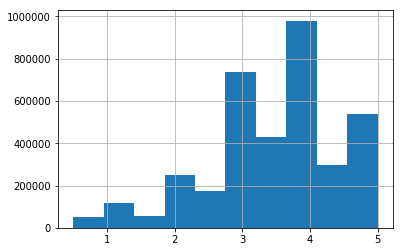

In [110]:
df_rating_test[config.rating_col].hist()

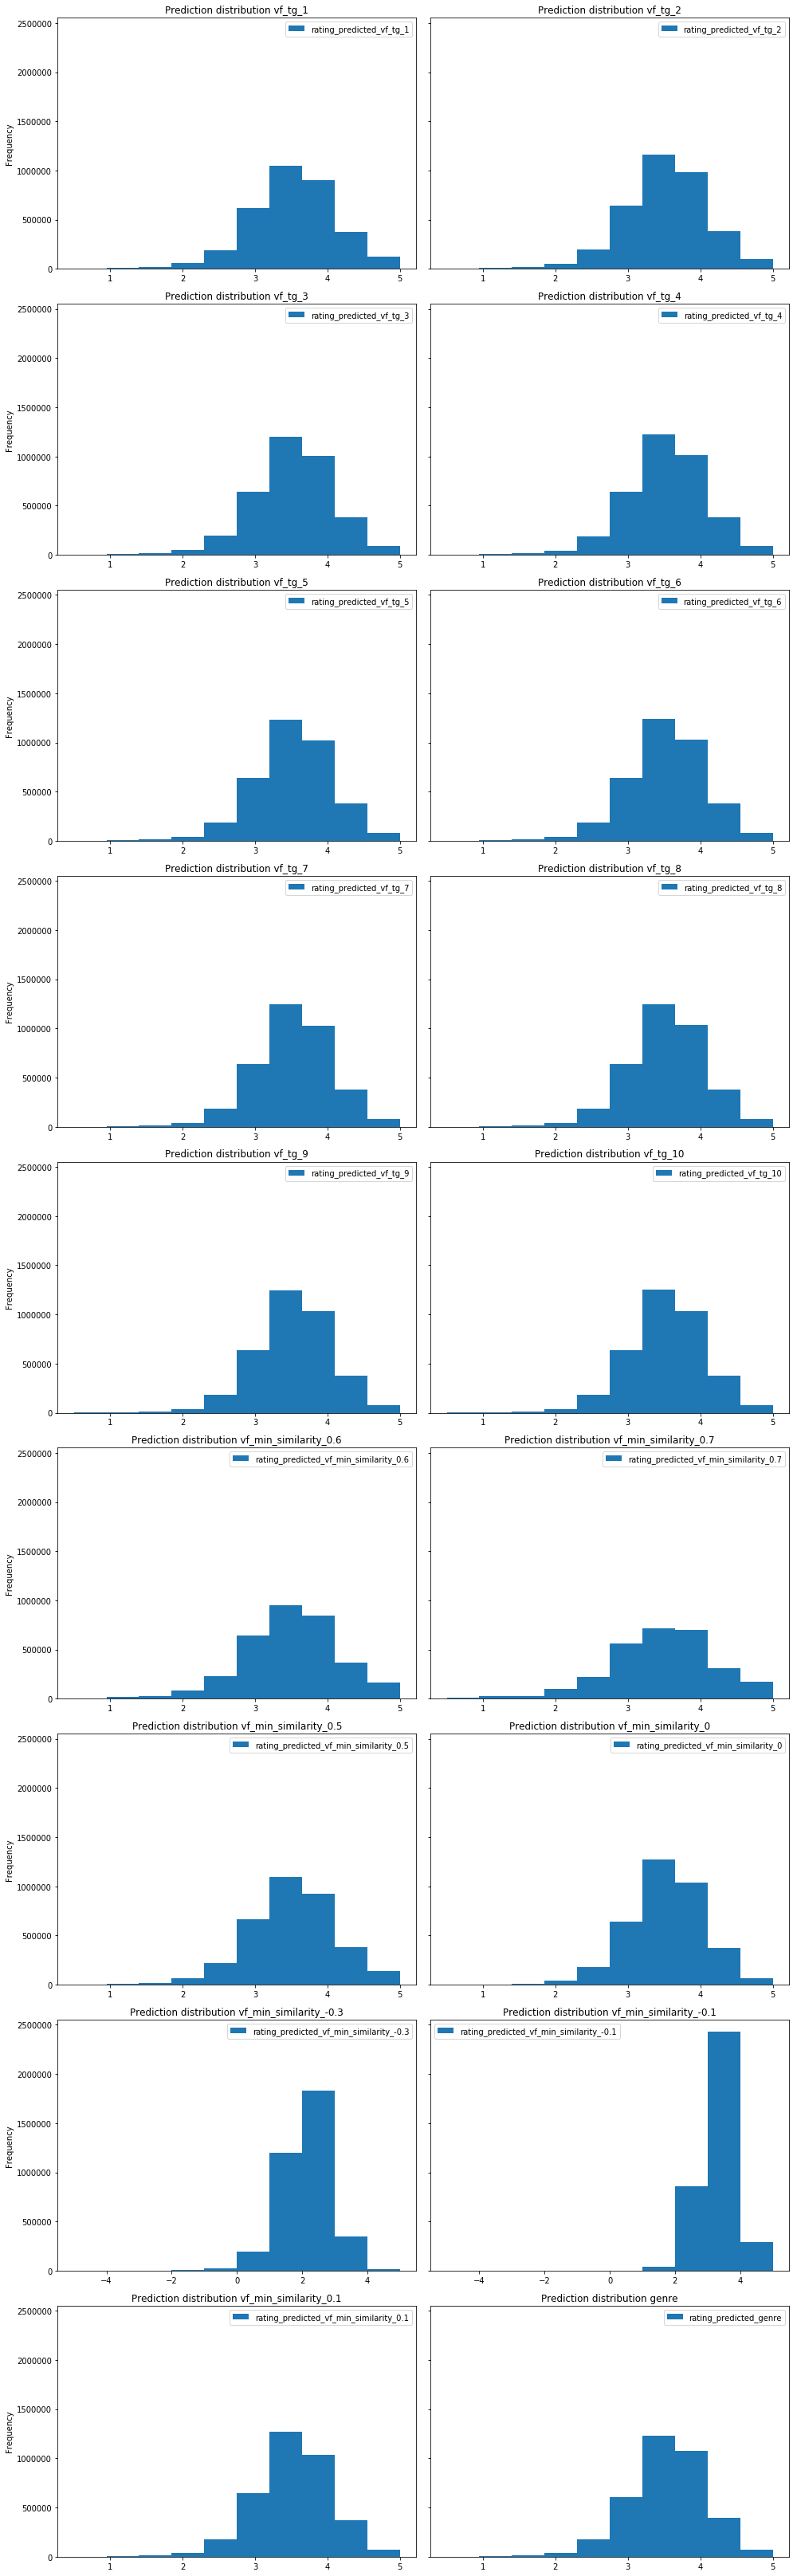

In [123]:
reload()
_ = tools.plot_side_by_side(tools.plot_prediction_histogram,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

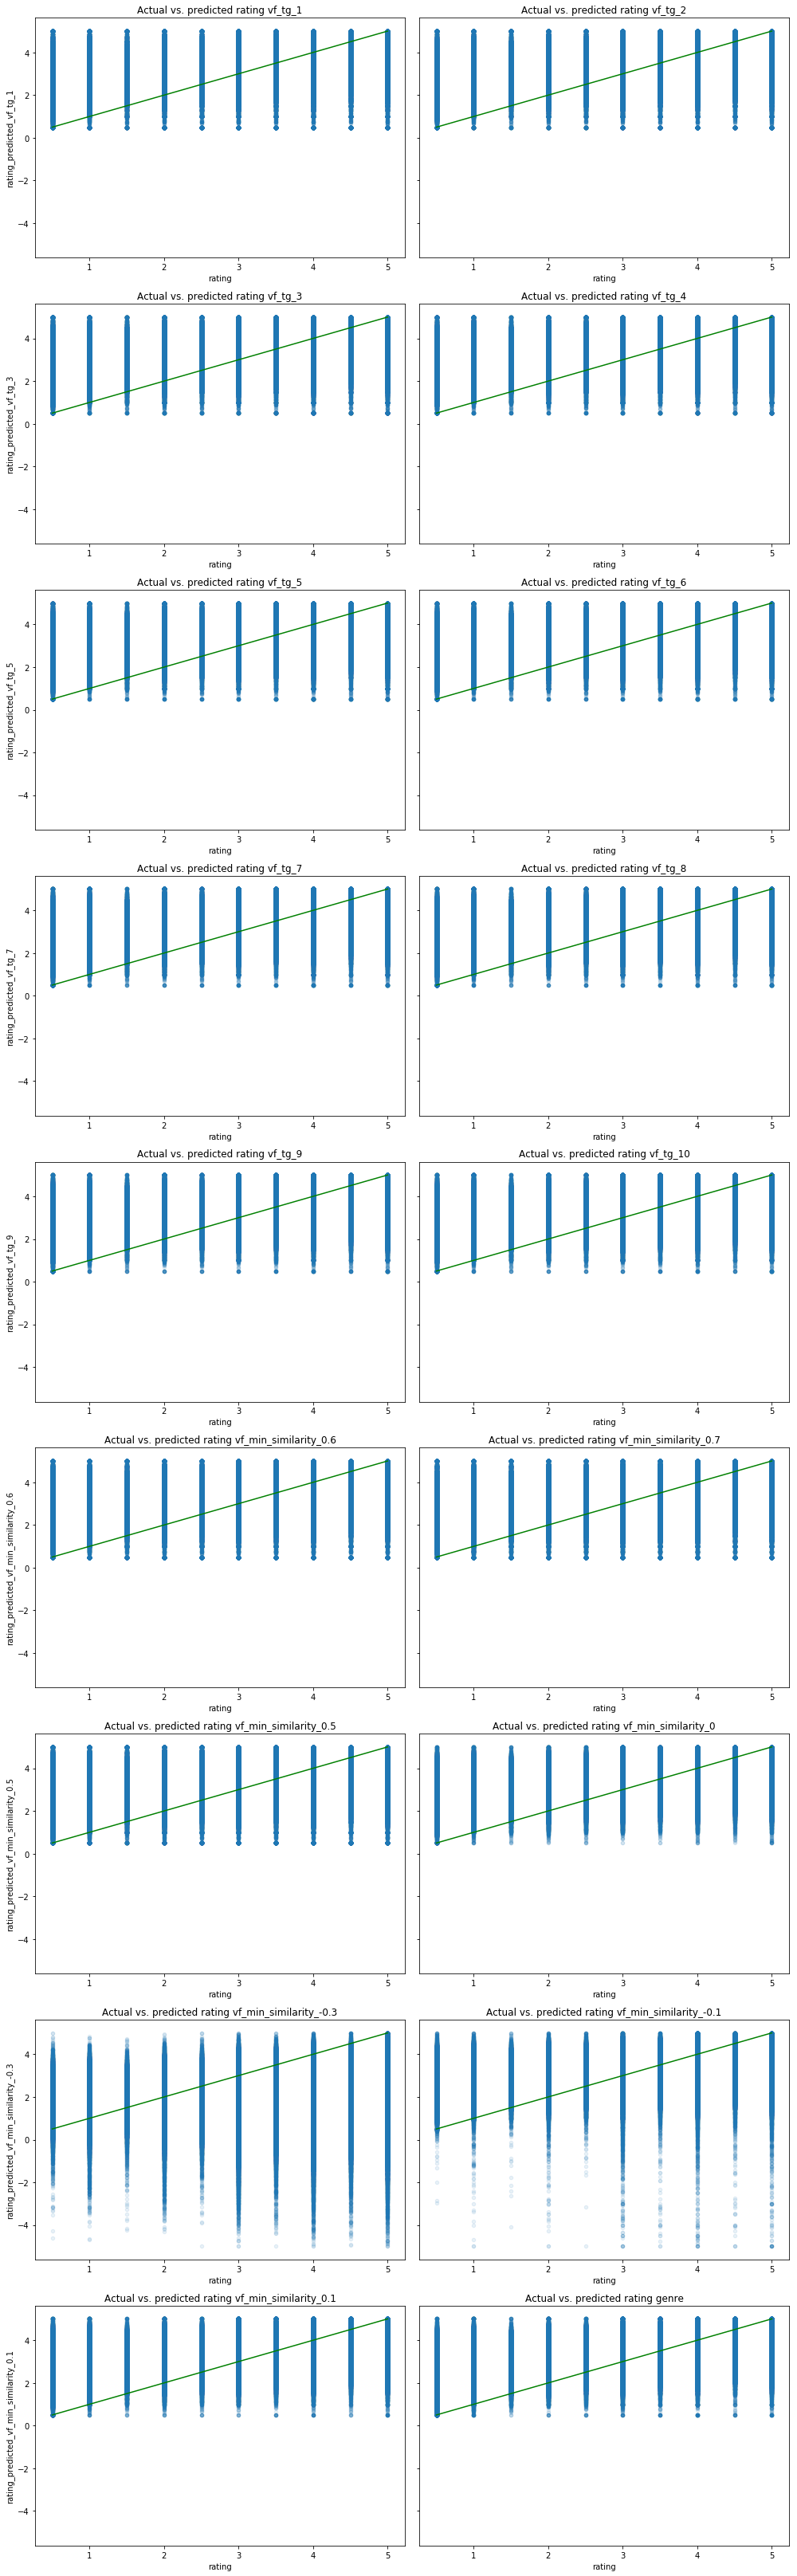

In [124]:
# reload()
# _ = tools.plot_side_by_side(tools.plot_actual_vs_prediction,
#                             df_rating_pred=df_rating_test,
#                             prediction_column_suffixes=prediction_column_suffixes,
#                             alpha=.1)

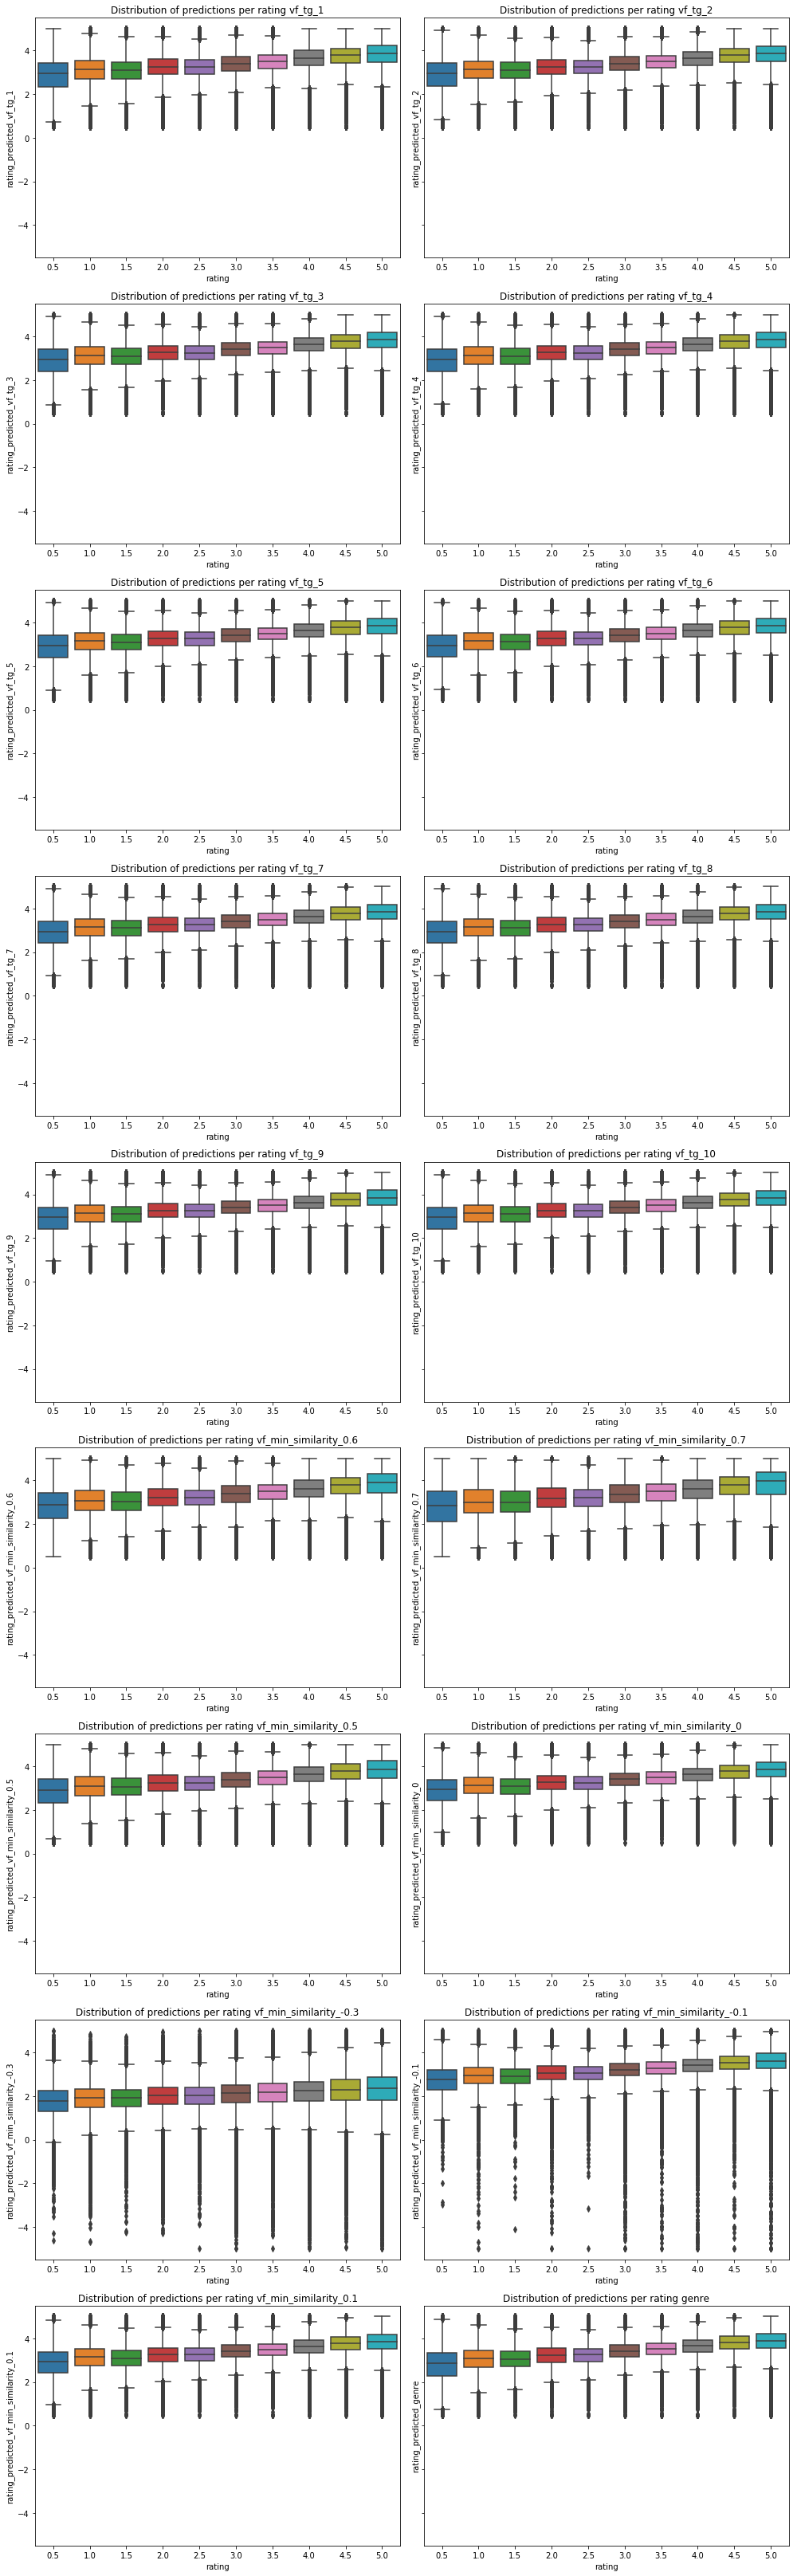

In [125]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

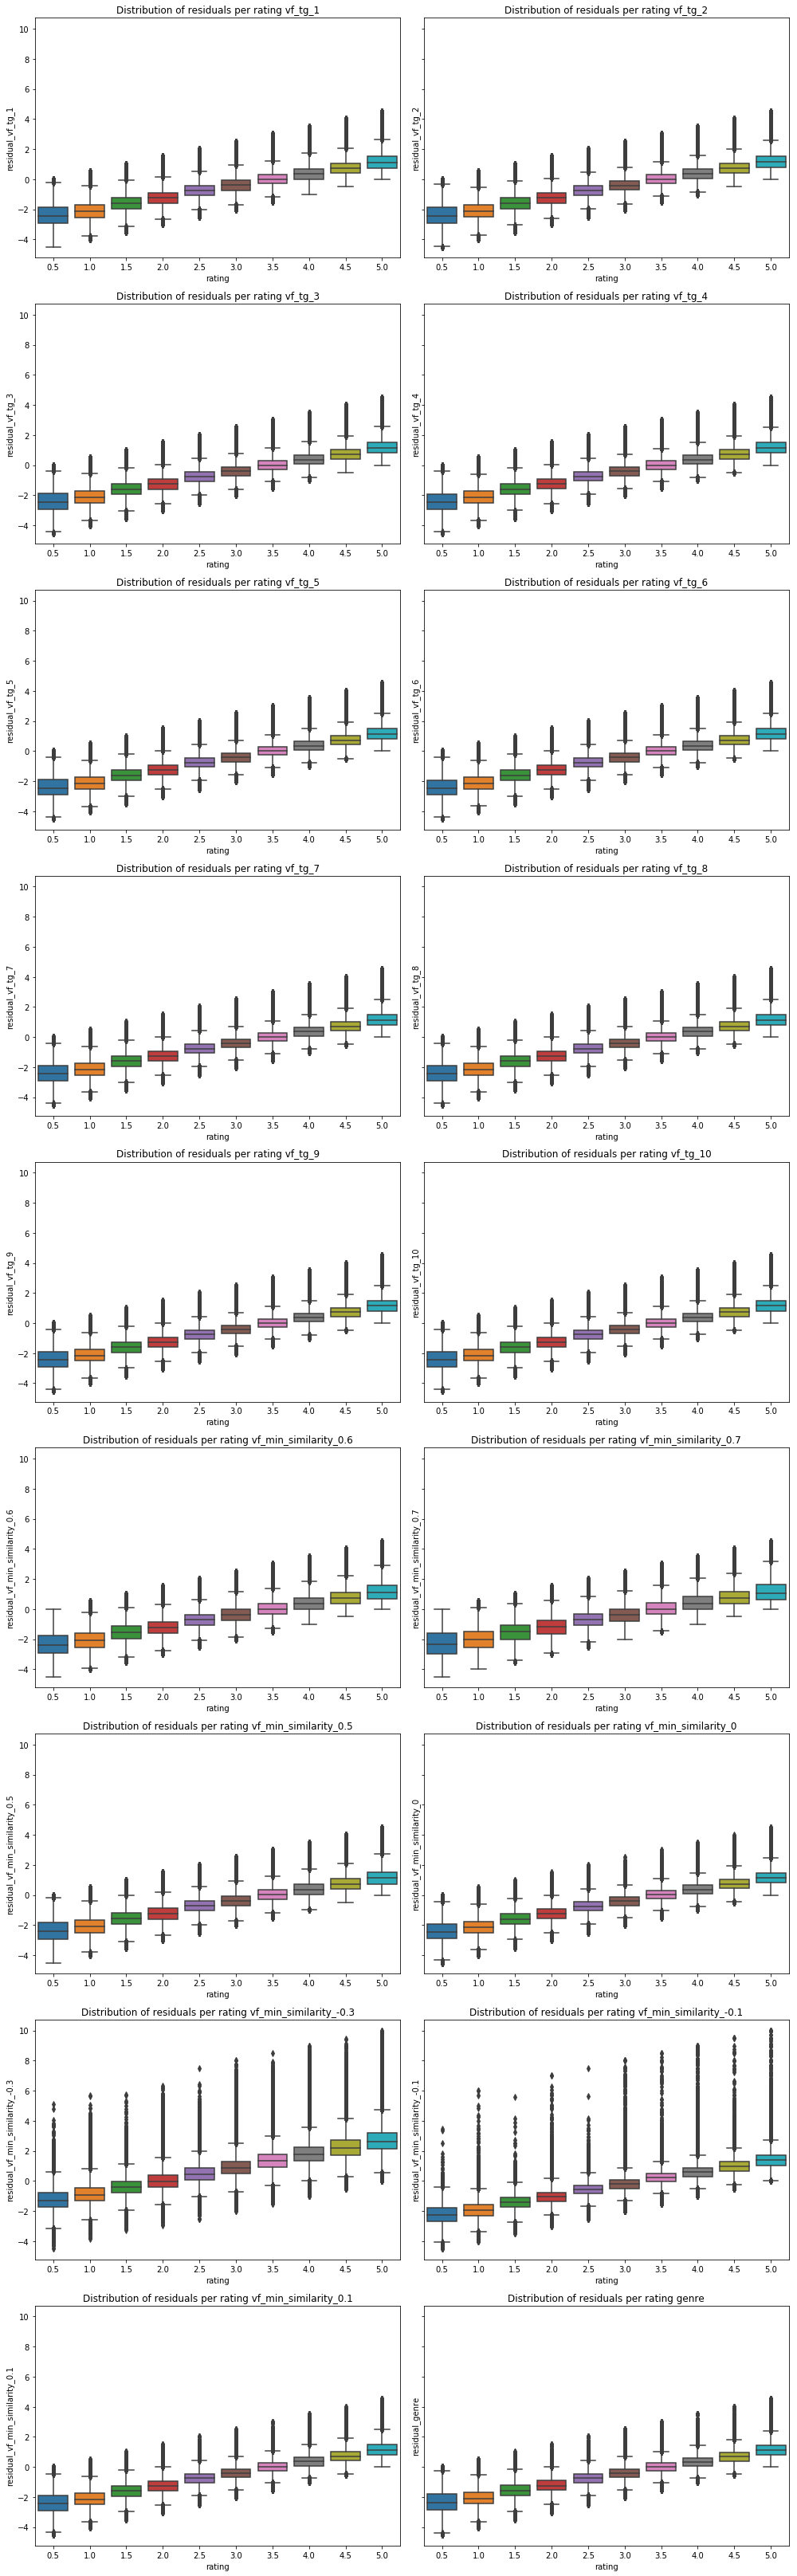

In [126]:
reload()
_ = tools.plot_side_by_side(tools.plot_residual_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

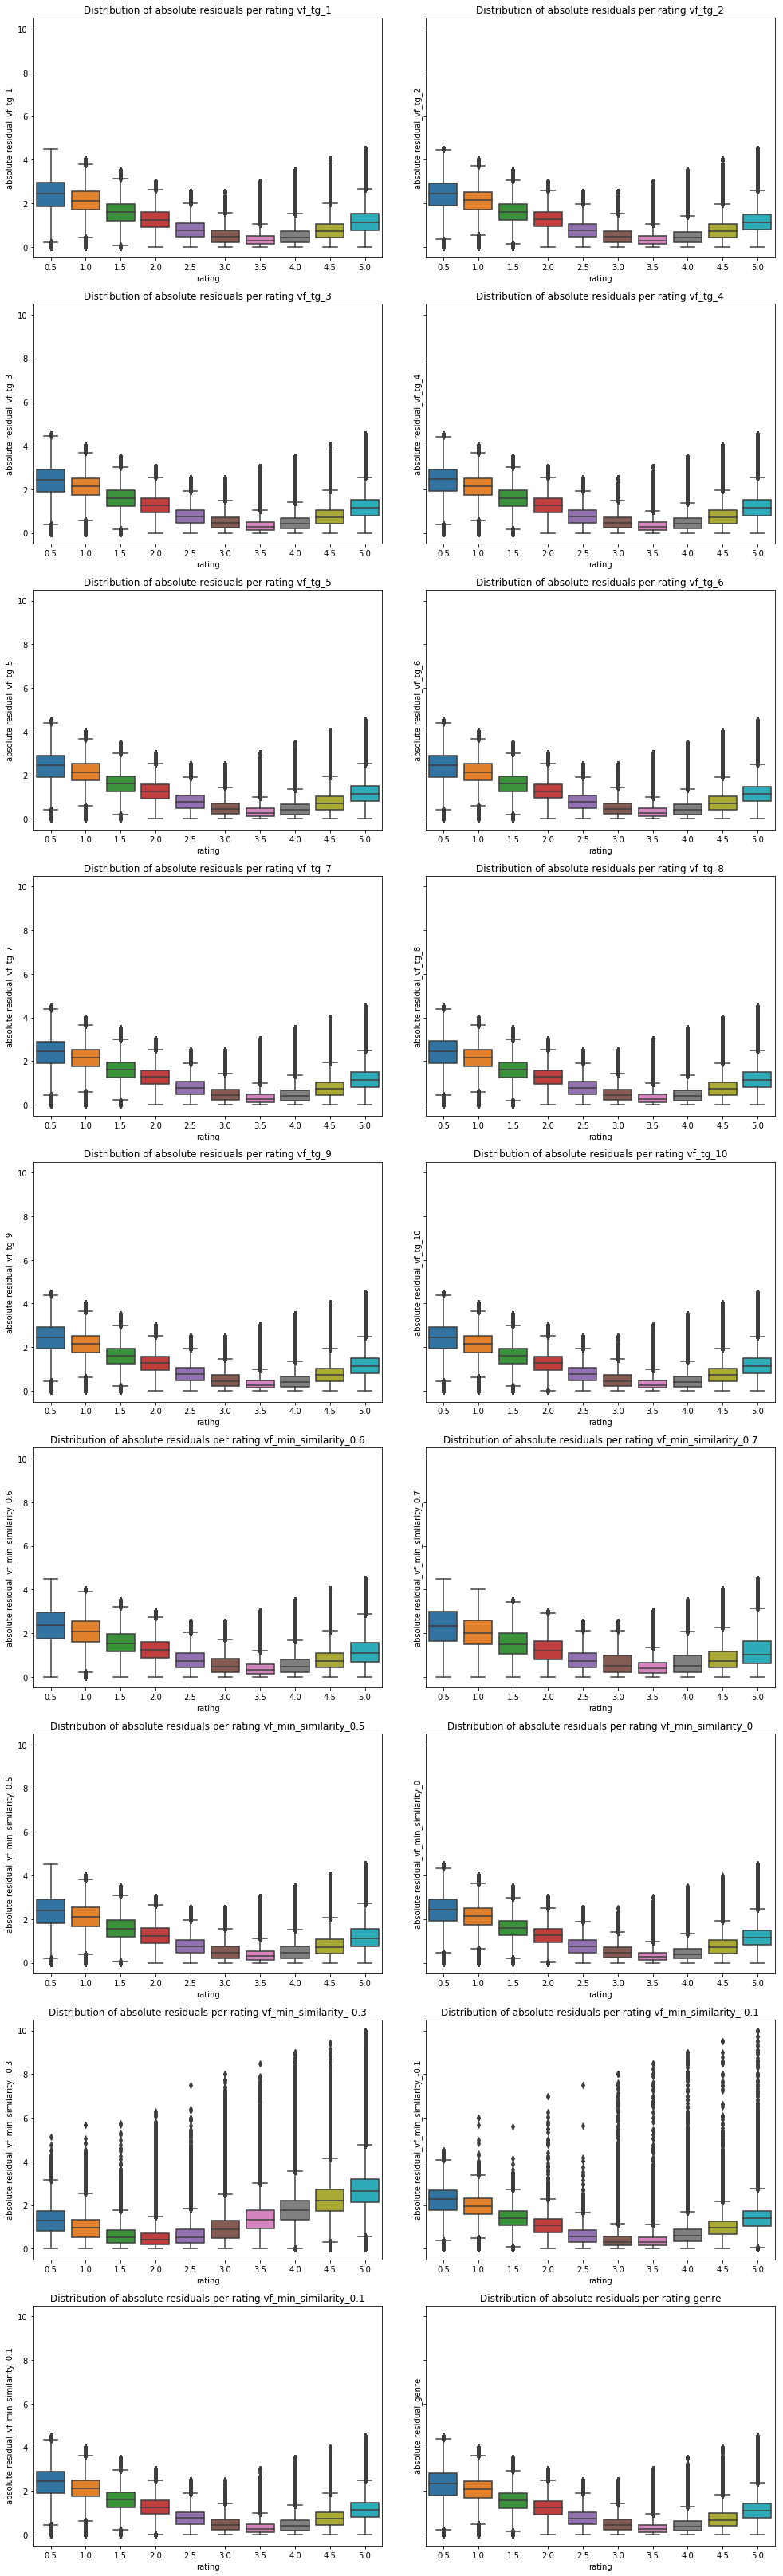

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_absolute_residual_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

In [ ]:
# reload()
# _ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_violinplot,
#                             df_rating_pred=df_rating_test,
#                             prediction_column_suffixes=prediction_column_suffixes)

# Save the current notebook into results folder and push to the repository

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
from notebook import notebookapp
import urllib
import json
import os
import ipykernel

currentTime = lambda : time.strftime('%Y-%m-%d-%H%M')
def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

notebook_dir, notebook_name = os.path.split(notebook_path())
output = os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}.ipynb')
os.system(f'jupyter nbconvert --to ipynb {notebook_path()} --output {output}')
os.system(f'git add {output}')
os.system(f'git commit -m "result computed on {currentTime()}"')
os.system('git push')

In [ ]:
df_rating_test.to_csv(os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}_df_rating_test.csv'))